In [39]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [40]:
class MachineReplacementEnv:
    def __init__(self, cost_function, transition_probs, num_states):
        self.cost_function = cost_function
        self.transition_probs = np.array(transition_probs)
        self.num_states = num_states
        self.num_actions = self.transition_probs.shape[1]
        self.state = 0
        self.N = np.zeros((self.num_states, self.num_actions))

        assert self.transition_probs.shape[0] == num_states
        assert self.transition_probs.shape[2] == num_states

        prob_sums = np.sum(self.transition_probs, axis=2)
        assert np.allclose(prob_sums, 1.0), "Transition probabilities must sum to 1"

    def reset(self):
        self.state = np.random.randint(0, self.num_states)
        return self.state

    def step(self, action):
        self.N[self.state, action] += 1
        cost = self.cost_function(self.state, action)
        reward = cost

        next_state_probs = self.transition_probs[self.state, action, :]
        next_state = np.random.choice(self.num_states, p=next_state_probs)

        self.state = next_state

        done = False

        info = {
            'cost': cost,
            'transition_prob': next_state_probs[next_state]
        }

        return self.state, reward, done, info

    def get_state_space_size(self):
        return self.num_states

    def get_action_space_size(self):
        return self.num_actions

In [41]:
class DynaAgent:
    def __init__(self, state_space_size, action_space_size,
                 learning_rate=0.1, discount_factor=0.9, epsilon=0.1,
                 planning_steps=5):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.planning_steps = planning_steps

        self.q_table = np.zeros((state_space_size, action_space_size))

        self.model = defaultdict(lambda: defaultdict(int))
        self.visited_state_actions = set()  # Track visited (state, action) pairs

    def is_visited(self, state, action):
        if (state, action) in self.visited_state_actions:
            return True
        return False

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_space_size)
        else:
            return np.argmin(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        transitions = self.model[(state, action)]
        if transitions:
            outcomes = list(transitions.keys())
            counts = np.array(list(transitions.values()), dtype=np.float64)
            probs = counts / counts.sum()
            expected_q = 0.0
            for (ns, r), p in zip(outcomes, probs):
                best_next_action = np.argmin(self.q_table[ns])
                expected_q += p * (r + self.gamma * self.q_table[ns, best_next_action])
            self.q_table[state, action] = expected_q
        else:
            best_next_action = np.argmin(self.q_table[next_state])
            td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
            td_error = td_target - self.q_table[state, action]
            self.q_table[state, action] += self.lr * td_error

    def update_model(self, state, action, reward, next_state):
        self.model[(state, action)][(next_state, reward)] += 1
        if not self.is_visited(state, action):
            self.visited_state_actions.add((state, action))

    def planning(self):
        for _ in range(self.planning_steps):
            if not self.visited_state_actions:
                break

            state, action = random.choice(list(self.visited_state_actions))

            transitions = self.model[(state, action)]

            transitions = self.model[(state, action)]
            outcomes = list(transitions.keys())
            counts = np.array(list(transitions.values()), dtype=np.float64)
            probs = counts / counts.sum()
            idx = np.random.choice(len(outcomes), p=probs)
            next_state, reward = outcomes[idx]

            self.update_q_table(state, action, reward, next_state)

    def learn(self, state, action, reward, next_state):
        self.update_q_table(state, action, reward, next_state)

        self.update_model(state, action, reward, next_state)

        self.planning()


In [42]:
def linear_cost_function(state, action):
    if action == 0:
        return 5 * state + 2
    else:
        return 50


def quadratic_cost_function(state, action):
    if action == 0:
        return state ** 2 + 10
    else:
        return 60


def create_simple_transition_matrix(num_states, failure_rate_factor=0.1):
    num_actions = 2
    transition_probs = np.zeros((num_states, num_actions, num_states))

    for state in range(num_states):
        if state < num_states - 1:
            # Probability of aging normally (state -> state + 1)
            failure_prob = min(failure_rate_factor * state, 0.8)
            age_prob = 1.0 - failure_prob

            transition_probs[state, 1, state + 1] = age_prob  # Age normally
            transition_probs[state, 1, 0] = failure_prob      # Fail and replace
        else:
            # At max age, machine must be replaced
            transition_probs[state, 1, 0] = 1.0

        # Action 0: Replace machine (always go to state 0)
        transition_probs[state, 0, 0] = 1.0

    return transition_probs


def create_complex_transition_matrix(num_states):
    num_actions = 2
    transition_probs = np.zeros((num_states, num_actions, num_states))

    for state in range(num_states):
        # Action 1: Keep machine
        if state < num_states - 1:
            # Multiple possible outcomes
            immediate_failure_prob = 0.05 * state  # Immediate failure
            major_failure_prob = 0.03 * state      # Major failure (replace)
            normal_aging_prob = 1.0 - immediate_failure_prob - major_failure_prob

            transition_probs[state, 1, 0] = immediate_failure_prob + major_failure_prob
            transition_probs[state, 1, state + 1] = normal_aging_prob
        else:
            # At max age
            transition_probs[state, 1, 0] = 1.0

        # Action 0: Replace machine
        transition_probs[state, 0, 0] = 1.0

    return transition_probs

def create_custom_cost_function(operating_costs, replacement_cost):
    def cost_function(state, action):
        if action == 0:  # Replace machine
            return replacement_cost
        else:  # Keep machine
            return operating_costs[state]

    return cost_function


In [43]:
def train_dyna_agent_custom(cost_function, transition_probs, num_states,
                           episodes=1000, max_steps_per_episode=50):

    # Initialize environment and agent
    env = MachineReplacementEnv(cost_function, transition_probs, num_states)
    agent = DynaAgent(
        state_space_size=env.get_state_space_size(),
        action_space_size=env.get_action_space_size(),
        learning_rate=0.1,
        discount_factor=0.9,
        epsilon=0.1,
    )

    # Training metrics
    episode_rewards = []
    episode_lengths = []
    avg_rewards = []
    q_tables_over_episodes = []  # Store Q-tables

    for episode in tqdm(range(episodes)):
        state = env.reset()
        total_reward = 0
        steps = 0

        for step in range(max_steps_per_episode):
            # Choose action
            action = agent.choose_action(state)

            # Take step in environment
            next_state, reward, done, info = env.step(action)

            # Learn from experience
            agent.learn(state, action, reward, next_state)

            # Update tracking
            total_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(total_reward / steps)
        episode_lengths.append(steps)
        avg_rewards.append(np.mean(episode_rewards[-100:]))
        q_tables_over_episodes.append(agent.q_table.copy())  # Store a copy of Q-table

        # Decay epsilon
        agent.epsilon = max(0.01, agent.epsilon * 0.995)

        # Print progress
        if (episode + 1) % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, "
                  f"Avg Length = {avg_length:.2f}, Epsilon = {agent.epsilon:.3f}")

    print("N table:", env.N)

    return agent, episode_rewards, episode_lengths, avg_rewards, agent.q_table, q_tables_over_episodes


In [44]:
def evaluate_policy(agent, env, num_episodes=100):
    total_rewards = []

    # Temporarily set epsilon to 0 for pure exploitation
    original_epsilon = agent.epsilon
    agent.epsilon = 0

    for _ in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(50):  # Max steps per episode
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state

            if done:
                break

        total_rewards.append(total_reward)

    # Restore original epsilon
    agent.epsilon = original_epsilon

    return np.mean(total_rewards), np.std(total_rewards)

In [45]:
def display_policy(agent, cost_function):
    print("\nLearned Policy:")
    print("State | Action  | Cost(Keep) | Cost(Replace) | Q(Keep) | Q(Replace)")
    print("-" * 70)

    policy = np.zeros((agent.state_space_size))

    actions = ['Replace', 'Keep']
    for state in range(agent.state_space_size):
        best_action = np.argmin(agent.q_table[state])
        cost_keep = cost_function(state, 0)
        cost_replace = cost_function(state, 1)
        q_keep = agent.q_table[state, 0]
        q_replace = agent.q_table[state, 1]

        policy[state] = best_action

        print(f"  {state:2d}  | {actions[best_action]:7s} | {cost_keep:10.1f} | "
              f"{cost_replace:12.1f} | {q_keep:7.2f} | {q_replace:9.2f}")

    return policy

In [46]:
print("\n" + "=" * 60)
print("CUSTOM EXAMPLE: User-defined costs and transitions")
print("=" * 60)

num_states = 10

operating_costs = [5, 8, 13, 21, 34, 55, 65, 75, 85, 95]
custom_cost_func = create_custom_cost_function(operating_costs, replacement_cost=40)

print("Custom Operating Costs: ", custom_cost_func)

custom_transitions = create_simple_transition_matrix(num_states, failure_rate_factor=0.2)

print("Custom TPM: ", custom_transitions)

agent_custom, rewards_custom, lengths_custom, avg_rewards, q_table, q_tables_over_episodes = train_dyna_agent_custom(
    custom_cost_func, custom_transitions, num_states, episodes=4000
)

env_custom = MachineReplacementEnv(custom_cost_func, custom_transitions, num_states)
mean_reward_custom, std_reward_custom = evaluate_policy(agent_custom, env_custom)
print(f"\nFinal Policy Evaluation: {mean_reward_custom:.2f} ± {std_reward_custom:.2f}")
policy = display_policy(agent_custom, custom_cost_func)
print("\nLearned Policy Array:", policy)

print(f"\nCustom Operating Costs: {operating_costs}")
print(f"Replacement Cost: 40")



CUSTOM EXAMPLE: User-defined costs and transitions
Custom Operating Costs:  <function create_custom_cost_function.<locals>.cost_function at 0x72924afe9bc0>
Custom TPM:  [[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.2 0.  0.8 0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.4 0.  0.  0.6 0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.6 0.  0.  0.  0.4 0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.2 0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.2 0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.2 0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.  0.2 0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.2]]

 [[1.  0.  0.  0.  0

  6%|▋         | 259/4000 [00:00<00:12, 291.92it/s]

Episode 200: Avg Reward = 12.62, Avg Length = 50.00, Epsilon = 0.037


 11%|█         | 437/4000 [00:01<00:12, 283.62it/s]

Episode 400: Avg Reward = 12.17, Avg Length = 50.00, Epsilon = 0.013


 16%|█▌        | 645/4000 [00:02<00:11, 289.05it/s]

Episode 600: Avg Reward = 12.04, Avg Length = 50.00, Epsilon = 0.010


 21%|██▏       | 852/4000 [00:02<00:10, 286.22it/s]

Episode 800: Avg Reward = 12.09, Avg Length = 50.00, Epsilon = 0.010


 26%|██▋       | 1055/4000 [00:03<00:10, 280.22it/s]

Episode 1000: Avg Reward = 12.39, Avg Length = 50.00, Epsilon = 0.010


 31%|███       | 1233/4000 [00:04<00:09, 285.22it/s]

Episode 1200: Avg Reward = 12.21, Avg Length = 50.00, Epsilon = 0.010


 36%|███▌      | 1440/4000 [00:05<00:08, 290.06it/s]

Episode 1400: Avg Reward = 12.19, Avg Length = 50.00, Epsilon = 0.010


 41%|████      | 1648/4000 [00:05<00:08, 288.75it/s]

Episode 1600: Avg Reward = 12.08, Avg Length = 50.00, Epsilon = 0.010


 46%|████▋     | 1853/4000 [00:06<00:07, 285.00it/s]

Episode 1800: Avg Reward = 12.30, Avg Length = 50.00, Epsilon = 0.010


 51%|█████     | 2030/4000 [00:07<00:06, 291.41it/s]

Episode 2000: Avg Reward = 12.15, Avg Length = 50.00, Epsilon = 0.010


 56%|█████▌    | 2240/4000 [00:07<00:06, 290.43it/s]

Episode 2200: Avg Reward = 12.10, Avg Length = 50.00, Epsilon = 0.010


 61%|██████    | 2449/4000 [00:08<00:05, 293.18it/s]

Episode 2400: Avg Reward = 12.03, Avg Length = 50.00, Epsilon = 0.010


 66%|██████▋   | 2658/4000 [00:09<00:04, 291.24it/s]

Episode 2600: Avg Reward = 12.23, Avg Length = 50.00, Epsilon = 0.010


 71%|███████   | 2838/4000 [00:09<00:03, 291.67it/s]

Episode 2800: Avg Reward = 12.16, Avg Length = 50.00, Epsilon = 0.010


 76%|███████▌  | 3046/4000 [00:10<00:03, 287.09it/s]

Episode 3000: Avg Reward = 12.39, Avg Length = 50.00, Epsilon = 0.010


 81%|████████▏ | 3252/4000 [00:11<00:02, 289.09it/s]

Episode 3200: Avg Reward = 11.89, Avg Length = 50.00, Epsilon = 0.010


 86%|████████▌ | 3430/4000 [00:11<00:01, 289.67it/s]

Episode 3400: Avg Reward = 12.12, Avg Length = 50.00, Epsilon = 0.010


 91%|█████████ | 3638/4000 [00:12<00:01, 289.56it/s]

Episode 3600: Avg Reward = 12.35, Avg Length = 50.00, Epsilon = 0.010


 96%|█████████▌| 3846/4000 [00:13<00:00, 296.08it/s]

Episode 3800: Avg Reward = 12.09, Avg Length = 50.00, Epsilon = 0.010


100%|██████████| 4000/4000 [00:13<00:00, 288.31it/s]

Episode 4000: Avg Reward = 12.26, Avg Length = 50.00, Epsilon = 0.010
N table: [[3.8400e+02 5.7966e+04]
 [3.7600e+02 5.6820e+04]
 [2.7200e+02 4.4685e+04]
 [1.6400e+02 2.6526e+04]
 [1.0716e+04 6.8000e+01]
 [4.0000e+02 7.0000e+00]
 [4.0900e+02 4.0000e+00]
 [4.2400e+02 6.0000e+00]
 [3.5400e+02 1.0000e+00]
 [4.1300e+02 5.0000e+00]]

Final Policy Evaluation: 607.13 ± 56.24

Learned Policy:
State | Action  | Cost(Keep) | Cost(Replace) | Q(Keep) | Q(Replace)
----------------------------------------------------------------------
   0  | Keep    |       40.0 |          5.0 |  138.30 |    109.22
   1  | Keep    |       40.0 |          8.0 |  138.30 |    115.80
   2  | Keep    |       40.0 |         13.0 |  138.30 |    122.43
   3  | Keep    |       40.0 |         21.0 |  138.30 |    129.80
   4  | Replace |       40.0 |         34.0 |  138.30 |    138.46
   5  | Replace |       40.0 |         55.0 |  138.30 |    153.30
   6  | Replace |       40.0 |         65.0 |  138.30 |    176.39
   7  | Rep

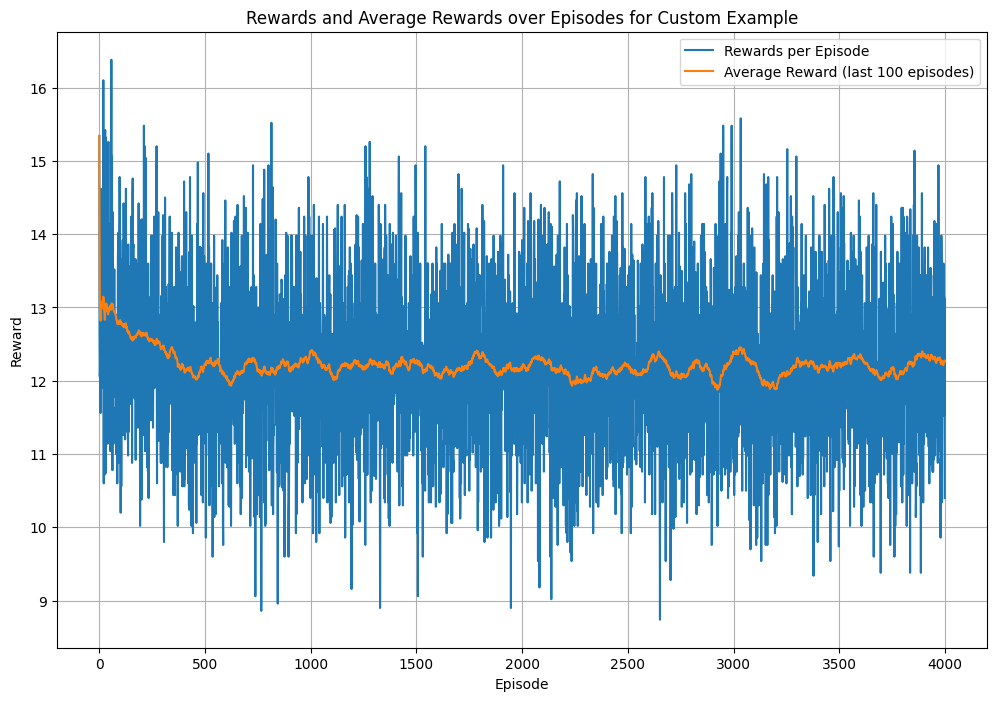

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.plot(rewards_custom, label="Rewards per Episode")
plt.plot(avg_rewards, label="Average Reward (last 100 episodes)")
plt.title("Rewards and Average Rewards over Episodes for Custom Example")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

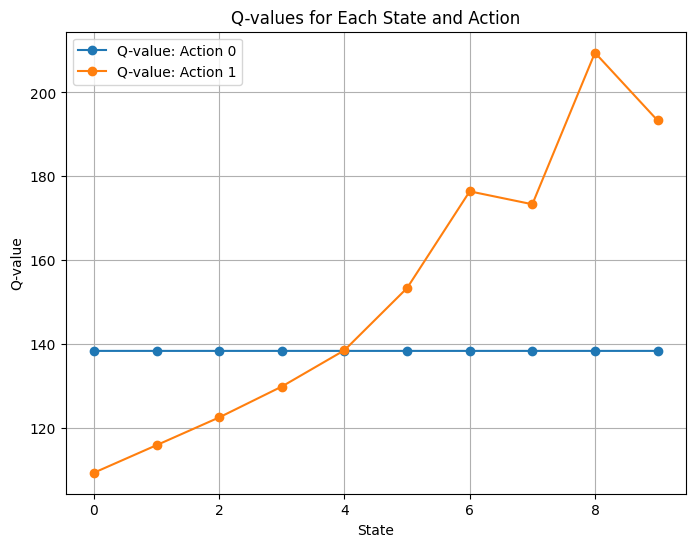

In [48]:
plt.figure(figsize=(8, 6))
for action in range(q_table.shape[1]):
    plt.plot(range(num_states), q_table[:, action], marker='o', label=f"Q-value: Action {action}")
plt.title("Q-values for Each State and Action")
plt.xlabel("State")
plt.ylabel("Q-value")
plt.legend()
plt.grid()
plt.show()

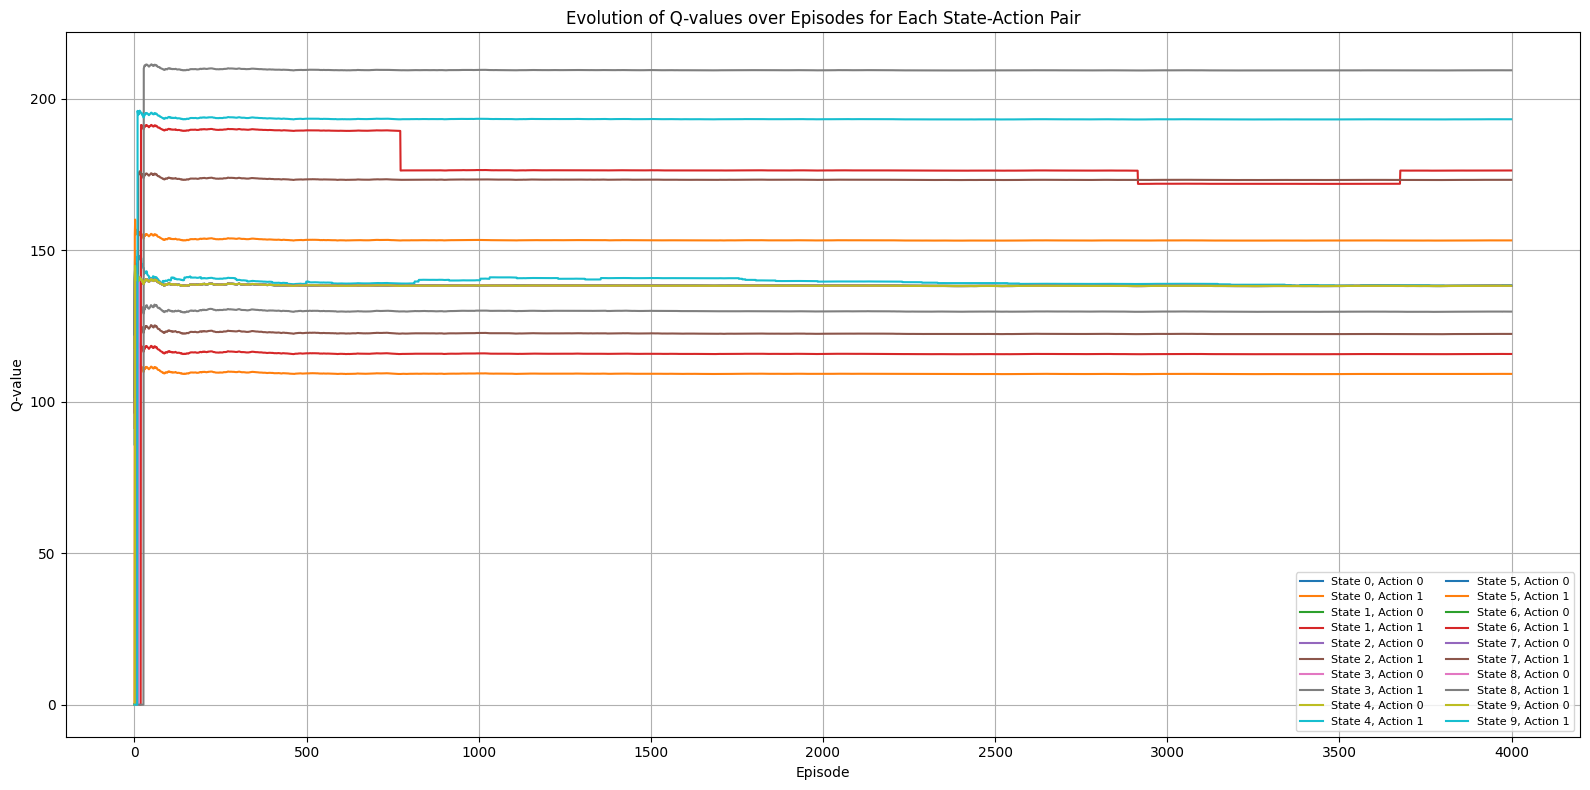

In [49]:
q_tables = np.array(q_tables_over_episodes)
num_episodes = q_tables.shape[0]
num_states = q_tables.shape[1]
num_actions = q_tables.shape[2]

plt.figure(figsize=(16, 8))
for state in range(num_states):
    for action in range(num_actions):
        plt.plot(range(num_episodes), q_tables[:, state, action], label=f"State {state}, Action {action}")
plt.xlabel("Episode")
plt.ylabel("Q-value")
plt.title("Evolution of Q-values over Episodes for Each State-Action Pair")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
def train_dyna_agent_with_env_change(cost_function_1, cost_function_2, transition_probs_1, transition_probs_2, num_states,
                           episodes=1000, max_steps_per_episode=50):

    # Initialize environment and agent
    env1 = MachineReplacementEnv(cost_function_1, transition_probs_1, num_states)
    agent = DynaAgent(
        state_space_size=env1.get_state_space_size(),
        action_space_size=env1.get_action_space_size(),
        learning_rate=0.1,
        discount_factor=0.9,
        epsilon=0.1,
        planning_steps=10
    )

    env2 = MachineReplacementEnv(cost_function_2, transition_probs_2, num_states)

    # Training metrics
    episode_rewards = []
    episode_lengths = []
    avg_rewards = []
    q_tables_over_episodes = []  # Store Q-tables

    for episode in tqdm(range(episodes)):
        if episode < episodes // 2:
            env = env1
        else:
            env = env2

        state = env.reset()
        total_reward = 0
        steps = 0

        for step in range(max_steps_per_episode):
            # Choose action
            action = agent.choose_action(state)

            # Take step in environment
            next_state, reward, done, info = env.step(action)

            # Learn from experience
            agent.learn(state, action, reward, next_state)

            # Update tracking
            total_reward += reward
            state = next_state
            steps += 1

            if done:
                break

        episode_rewards.append(total_reward / steps)
        episode_lengths.append(steps)
        avg_rewards.append(np.mean(episode_rewards[-100:]))
        q_tables_over_episodes.append(agent.q_table.copy())  # Store a copy of Q-table

        # Decay epsilon
        agent.epsilon = max(0.01, agent.epsilon * 0.995)

        # Print progress
        if (episode + 1) % 200 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, "
                  f"Avg Length = {avg_length:.2f}, Epsilon = {agent.epsilon:.3f}")

    print("N table:", env.N)

    return agent, episode_rewards, episode_lengths, avg_rewards, agent.q_table, q_tables_over_episodes

In [ ]:
num_states = 10

operating_costs_1 = [5, 8, 13, 21, 34, 55, 55, 55, 55, 55]
custom_cost_func_1 = create_custom_cost_function(operating_costs, replacement_cost=40)

operating_costs_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
custom_cost_func_2 = create_custom_cost_function(operating_costs_2, replacement_cost=40)

print("Custom Operating Costs: ", custom_cost_func)

# Custom transition matrix (high failure rate after state 3)
custom_transitions_1 = create_simple_transition_matrix(num_states, failure_rate_factor=0.2)
custom_transitions_2 = create_complex_transition_matrix(num_states)

print("Custom TPM: ", custom_transitions_1)
print("Custom TPM: ", custom_transitions_2)

agent_custom, rewards_custom, lengths_custom, avg_rewards, q_table, q_tables_over_episodes= train_dyna_agent_with_env_change(
    custom_cost_func_1, custom_cost_func_2, custom_transitions_1, custom_transitions_2, num_states, episodes=4000
)

env_custom = MachineReplacementEnv(custom_cost_func, custom_transitions, num_states)
mean_reward_custom, std_reward_custom = evaluate_policy(agent_custom, env_custom)
print(f"\nFinal Policy Evaluation: {mean_reward_custom:.2f} ± {std_reward_custom:.2f}")
policy = display_policy(agent_custom, custom_cost_func)
print("\nLearned Policy Array:", policy)


Custom Operating Costs:  <function create_custom_cost_function.<locals>.cost_function at 0x72924afe9bc0>
Custom TPM:  [[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.2 0.  0.8 0.  0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.4 0.  0.  0.6 0.  0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.6 0.  0.  0.  0.4 0.  0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.2 0.  0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.2 0.  0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.2 0.  0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.  0.2 0. ]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.2]]

 [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
  [1.  0.  0.  0.  0.  0.  0

  6%|▌         | 221/4000 [00:01<00:22, 165.32it/s]

Episode 200: Avg Reward = 12.35, Avg Length = 50.00, Epsilon = 0.037


 11%|█         | 425/4000 [00:02<00:22, 161.97it/s]

Episode 400: Avg Reward = 12.22, Avg Length = 50.00, Epsilon = 0.013


 16%|█▌        | 629/4000 [00:03<00:20, 163.56it/s]

Episode 600: Avg Reward = 12.14, Avg Length = 50.00, Epsilon = 0.010


 21%|██        | 833/4000 [00:05<00:19, 163.77it/s]

Episode 800: Avg Reward = 12.01, Avg Length = 50.00, Epsilon = 0.010


 26%|██▌       | 1020/4000 [00:06<00:18, 162.11it/s]

Episode 1000: Avg Reward = 12.16, Avg Length = 50.00, Epsilon = 0.010


 31%|███       | 1224/4000 [00:07<00:17, 162.00it/s]

Episode 1200: Avg Reward = 12.05, Avg Length = 50.00, Epsilon = 0.010


 36%|███▌      | 1428/4000 [00:08<00:15, 161.36it/s]

Episode 1400: Avg Reward = 12.26, Avg Length = 50.00, Epsilon = 0.010


 41%|████      | 1632/4000 [00:10<00:14, 161.59it/s]

Episode 1600: Avg Reward = 12.59, Avg Length = 50.00, Epsilon = 0.010


 45%|████▌     | 1819/4000 [00:11<00:13, 161.93it/s]

Episode 1800: Avg Reward = 12.06, Avg Length = 50.00, Epsilon = 0.010


 51%|█████     | 2023/4000 [00:12<00:12, 161.39it/s]

Episode 2000: Avg Reward = 12.38, Avg Length = 50.00, Epsilon = 0.010


 55%|█████▌    | 2216/4000 [00:13<00:11, 151.74it/s]

Episode 2200: Avg Reward = 6.25, Avg Length = 50.00, Epsilon = 0.010


 61%|██████    | 2424/4000 [00:15<00:10, 151.41it/s]

Episode 2400: Avg Reward = 6.21, Avg Length = 50.00, Epsilon = 0.010


 65%|██████▌   | 2615/4000 [00:16<00:09, 152.22it/s]

Episode 2600: Avg Reward = 5.10, Avg Length = 50.00, Epsilon = 0.010


 70%|███████   | 2818/4000 [00:17<00:08, 147.03it/s]

Episode 2800: Avg Reward = 4.55, Avg Length = 50.00, Epsilon = 0.010


 75%|███████▌  | 3015/4000 [00:19<00:06, 148.46it/s]

Episode 3000: Avg Reward = 4.35, Avg Length = 50.00, Epsilon = 0.010


 81%|████████  | 3225/4000 [00:20<00:05, 143.80it/s]

Episode 3200: Avg Reward = 4.36, Avg Length = 50.00, Epsilon = 0.010


 86%|████████▌ | 3421/4000 [00:21<00:04, 144.09it/s]

Episode 3400: Avg Reward = 3.93, Avg Length = 50.00, Epsilon = 0.010


 90%|█████████ | 3616/4000 [00:23<00:02, 146.63it/s]

Episode 3600: Avg Reward = 4.00, Avg Length = 50.00, Epsilon = 0.010


 96%|█████████▌| 3829/4000 [00:24<00:01, 149.31it/s]

Episode 3800: Avg Reward = 3.89, Avg Length = 50.00, Epsilon = 0.010


100%|██████████| 4000/4000 [00:25<00:00, 155.20it/s]

Episode 4000: Avg Reward = 4.11, Avg Length = 50.00, Epsilon = 0.010
N table: [[9.3000e+01 2.0443e+04]
 [9.9000e+01 2.0112e+04]
 [8.0000e+01 1.8288e+04]
 [8.7000e+01 1.5091e+04]
 [6.2000e+01 1.1371e+04]
 [1.6140e+03 6.1540e+03]
 [7.3500e+02 3.1480e+03]
 [8.1100e+02 9.8500e+02]
 [5.9800e+02 6.0000e+00]
 [9.1000e+01 1.3200e+02]]

Final Policy Evaluation: 638.52 ± 76.61

Learned Policy:
State | Action  | Cost(Keep) | Cost(Replace) | Q(Keep) | Q(Replace)
----------------------------------------------------------------------
   0  | Keep    |       40.0 |          5.0 |  101.82 |     68.69
   1  | Keep    |       40.0 |          8.0 |  101.82 |     72.61
   2  | Keep    |       40.0 |         13.0 |  101.82 |     75.62
   3  | Keep    |       40.0 |         21.0 |  101.82 |     77.06
   4  | Keep    |       40.0 |         34.0 |  101.82 |     74.99
   5  | Keep    |       40.0 |         55.0 |  101.82 |     71.59
   6  | Keep    |       40.0 |         65.0 |  101.82 |     75.45
   7  | Keep

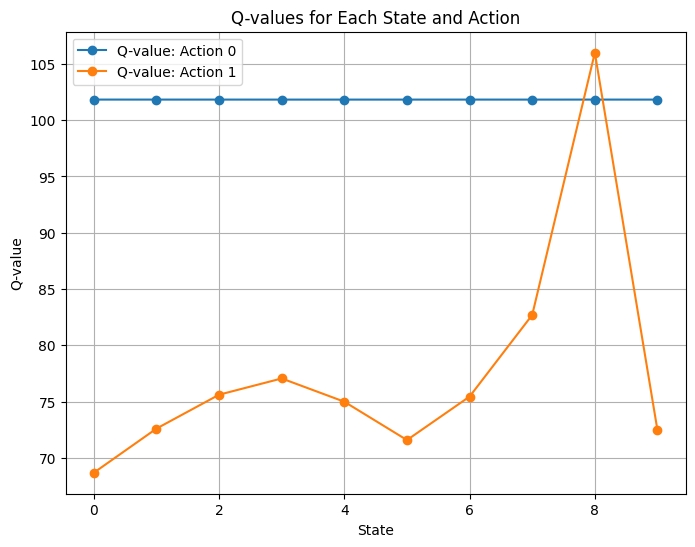

In [52]:
plt.figure(figsize=(8, 6))
for action in range(q_table.shape[1]):
    plt.plot(range(num_states), q_table[:, action], marker='o', label=f"Q-value: Action {action}")
plt.title("Q-values for Each State and Action")
plt.xlabel("State")
plt.ylabel("Q-value")
plt.legend()
plt.grid()
plt.show()

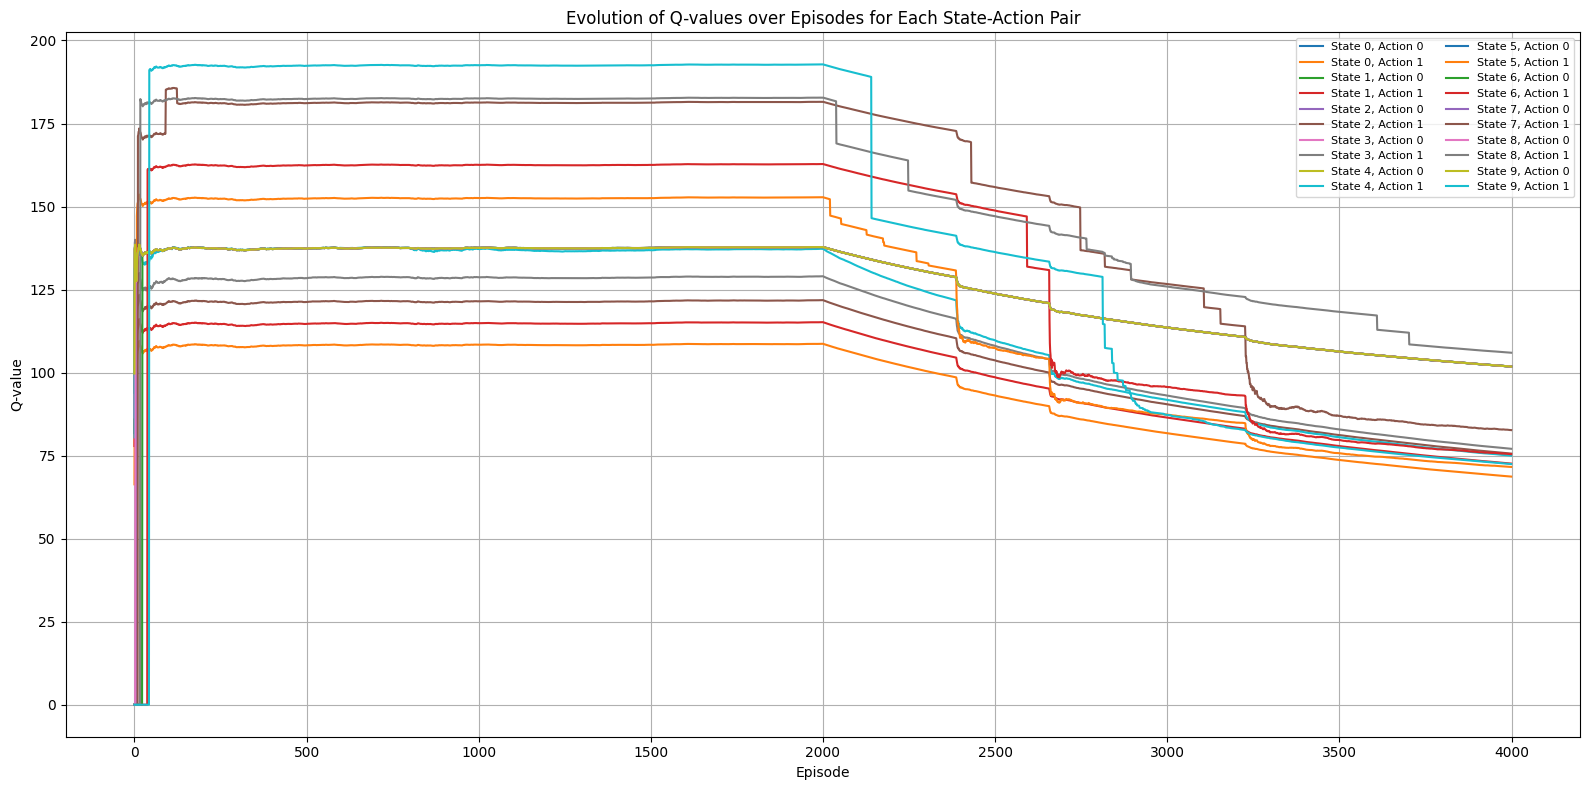

In [53]:
q_tables = np.array(q_tables_over_episodes)  # Shape: (num_episodes, num_states, num_actions)
num_episodes = q_tables.shape[0]
num_states = q_tables.shape[1]
num_actions = q_tables.shape[2]

plt.figure(figsize=(16, 8))
for state in range(num_states):
    for action in range(num_actions):
        plt.plot(range(num_episodes), q_tables[:, state, action], label=f"State {state}, Action {action}")
plt.xlabel("Episode")
plt.ylabel("Q-value")
plt.title("Evolution of Q-values over Episodes for Each State-Action Pair")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()